# **STINTSY Machine Project**

## *Group # - S16*
- **Ang, Danielle Faith**
- **De Los Santos, Hanna Angela**
- **Robles, Luis Miguel**
- **Sarreal, Sophia Althea**

# **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import skew

# **Dataset Description**

The file contains data about expenditures and other disbursements, housing characteristics, social protection, Income and other receipts and Entrepreneural Activities.

# **Structure of the Dataset**

# **Reading the Dataset**

In [ ]:
fies_df = pd.read_csv('FIES PUF 2012 Vol.1.CSV')

# **Cleaning the Dataset**

In [ ]:
display(fies_df.head())

,W_REGN,W_OID,W_SHSN,W_HCN,URB,RSTR,PSU,BWEIGHT,RFACT,FSIZE,...,PC_QTY,OVEN_QTY,MOTOR_BANCA_QTY,MOTORCYCLE_QTY,POP_ADJ,PCINC,NATPC,NATDC,REGDC,REGPC
0,14,101001000,2,25,2,21100,415052,138.25,200.6576,3.0,...,01,01,,,0.946172,108417.00,9,8,8,9
1,14,101001000,3,43,2,21100,415052,138.25,200.6576,12.5,...,,01,,01,0.946172,30631.60,5,9,9,4
2,14,101001000,4,62,2,21100,415052,138.25,200.6576,2.0,...,,01,,,0.946172,86992.50,9,6,6,8
3,14,101001000,5,79,2,21100,415052,138.25,200.6576,4.0,...,,01,,,0.946172,43325.75,6,6,6,6
4,14,101001000,10,165,2,21100,415052,138.25,200.6576,5.0,...,,,,01,0.946172,37481.80,6,6,6,5


In [ ]:
fies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40171 entries, 0 to 40170
Columns: 119 entries, W_REGN to REGPC
dtypes: float64(5), int64(92), object(22)
memory usage: 36.5+ MB


In [ ]:
object_columns = fies_df.select_dtypes(include=['object']).columns
print("Categorical Variables (Object Dtypes):")
print(object_columns)

Categorical Variables (Object Dtypes):
Index(['OCCUP', 'KB', 'CW', 'AGELESS5', 'AGE5_17', 'EMPLOYED_PAY',
       'EMPLOYED_PROF', 'DISTANCE', 'RADIO_QTY', 'TV_QTY', 'CD_QTY',
       'STEREO_QTY', 'REF_QTY', 'WASH_QTY', 'AIRCON_QTY', 'CAR_QTY',
       'LANDLINE_QTY', 'CELLPHONE_QTY', 'PC_QTY', 'OVEN_QTY',
       'MOTOR_BANCA_QTY', 'MOTORCYCLE_QTY'],
      dtype='object')


In [ ]:
cols = ['AGELESS5', 'AGE5_17', 'EMPLOYED_PAY',
       'EMPLOYED_PROF', 'DISTANCE', 'RADIO_QTY', 'TV_QTY', 'CD_QTY',
       'STEREO_QTY', 'REF_QTY', 'WASH_QTY', 'AIRCON_QTY', 'CAR_QTY',
       'LANDLINE_QTY', 'CELLPHONE_QTY', 'PC_QTY', 'OVEN_QTY',
       'MOTOR_BANCA_QTY', 'MOTORCYCLE_QTY']

fies_df[cols] = fies_df[cols].apply(pd.to_numeric, errors='coerce')


### **`HGC`** - ***(Household Head) Highest Grade Completed***

The **HGC** variable represents the highest level of education completed by the household head.

### **Education Levels and Codes:**

- **No Grade Completed:** `0`  
- **Preschool:** `10`  
- **Elementary Undergraduate:** `210-260`  
- **Elementary Graduate:** `280`  
- **High School Undergraduate:** `310-330`  
- **High School Graduate:** `350`  
- **Post-Secondary Undergraduate:** `410-420`  
- **Post-Secondary Graduate (Technical/Vocational):** `501-589`  
- **College Undergraduate:** `810-840`  
- **College Graduate:** `601-689`  
- **Post-Baccalaureate:** `900`  

In [ ]:
fies_df["HGC"].unique()

array([280, 250, 552, 830, 350, 634, 554, 320, 514, 240, 581, 810, 614,
       900, 652, 330,   0, 840, 230, 584, 534, 562, 220, 310, 210, 622,
       410, 686, 572, 662, 672, 820, 260, 681, 420, 631, 684, 642, 648,
       601, 646, 676, 586, 589, 658, 689, 501, 621, 548, 632, 654, 638,
       664,  10, 522, 685, 521, 644, 542, 531, 558, 532])

As seen by using **`.unique()`**, these codes are not continuous single values, but instead appear in ranges for certain education levels.

With this, we mapped these numerical codes into standardized categories based on the dictionary.

<small>***Note that the dictionary lists College Undergraduate as ranging from **810-840** and College Graduate as **601-689**, so their values in the mapping may seem reversed.* </small>

In [ ]:
print(fies_df["HGC"].between(601, 689).sum())  # Expected graduates
print(fies_df["HGC"].between(810, 840).sum())  # Expected undergraduates


4210
3237


In [ ]:
conditions = [
    (fies_df["HGC"] == 0),
    (fies_df["HGC"] == 10),
    (fies_df["HGC"].between(210, 260)),
    (fies_df["HGC"] == 280),
    (fies_df["HGC"].between(310, 330)),
    (fies_df["HGC"] == 350),
    (fies_df["HGC"].between(410, 420)),
    (fies_df["HGC"].between(501, 589)),
    (fies_df["HGC"].between(810, 840)),
    (fies_df["HGC"].between(601, 689)),
    (fies_df["HGC"] >= 900)
]

values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

fies_df["HGC"] = np.select(conditions, values, default=np.nan)

fies_df["HGC"]

,HGC
0,3.0
1,2.0
2,7.0
3,8.0
4,5.0
...,...
40166,5.0
40167,5.0
40168,2.0
40169,3.0


### **`OCCUP`** - ***Primary occupation of the head of the family during the past six months***

In [ ]:
fies_df['OCCUP'].unique()

array(['    ', '1314', '6111', '5220', '6212', '6114', '5132', '7122',
       '9211', '1316', '4121', '1130', '8322', '2331', '3118', '9132',
       '7241', '1312', '7231', '1317', '7123', '4115', '4142', '1120',
       '8324', '8263', '8321', '9131', '9112', '3152', '9133', '6420',
       '1430', '2341', '4215', '6119', '7433', '9313', '1412', '5162',
       '2449', '3450', '6219', '8141', '6112', '6122', '9151', '5169',
       '6116', '6124', '6121', '7243', '7422', '5123', '2310', '1490',
       '3434', '4190', '2412', '6310', '7414', '8275', '3415', '3151',
       '9333', '7212', '9322', '9311', '4113', '2152', '3431', '1319',
       '7141', '1224', '1231', '3131', '4211', '7242', '9120', '6330',
       '5151', '1313', '6340', '7111', '9212', '8222', '5139', '9213',
       '2154', '8231', '9312', '4131', '2224', '9152', '8113', '0129',
       '6129', '5131', '6115', '7415', '0121', '8323', '3232', '5161',
       '3416', '7432', '9161', '3132', '1315', '2221', '9111', '4133',
      

In [ ]:
fies_df['OCCUP'] = fies_df['OCCUP'].apply(pd.to_numeric, errors='coerce')

In [ ]:
conditions = [
    fies_df["OCCUP"].between(1110, 1490),
    fies_df["OCCUP"].between(2111, 2460),
    fies_df["OCCUP"].between(3111, 3480),
    fies_df["OCCUP"].between(4111, 4223),
    fies_df["OCCUP"].between(5111, 5230),
    fies_df["OCCUP"].between(6111, 6590),
    fies_df["OCCUP"].between(7111, 7442),
    fies_df["OCCUP"].between(8111, 8340),
    fies_df["OCCUP"].between(9111, 9333),
    fies_df["OCCUP"].isin([111, 112, 113, 121, 122, 123, 124, 125, 126, 127, 128, 129, 930])
]

values = [
    "Officials & Executives",
    "Professionals",
    "Technicians",
    "Clerks",
    "Service Workers",
    "Farmers & Fishers",
    "Trades Workers",
    "Machine Operators",
    "Laborers",
    "Special Occupations"
]

fies_df["OCCUP_GROUP"] = np.select(conditions, values, default="Unknown")

fies_df["OCCUP_GROUP"]

,OCCUP_GROUP
0,Unknown
1,Officials & Executives
2,Unknown
3,Farmers & Fishers
4,Service Workers
...,...
40166,Officials & Executives
40167,Machine Operators
40168,Officials & Executives
40169,Officials & Executives


In [ ]:
fies_df = pd.get_dummies(fies_df, columns=["OCCUP_GROUP"], drop_first=True, dtype=int)


### **`KB`** - ***Household Head Kind of Business/Industry***

In [ ]:
fies_df['KB'] = fies_df['KB'].apply(pd.to_numeric, errors='coerce')

In [ ]:
conditions = [
    fies_df["KB"].between(111, 329),
    fies_df["KB"].between(510, 990),
    fies_df["KB"].between(1011, 3320),
    fies_df["KB"].between(3510, 3530),
    fies_df["KB"].between(3600, 3900),
    fies_df["KB"].between(4100, 4390),
    fies_df["KB"].between(4510, 4799),
    fies_df["KB"].between(4911, 5320),
    fies_df["KB"].between(5510, 5630),
    fies_df["KB"].between(5811, 6399),
    fies_df["KB"].between(6411, 6630),
    fies_df["KB"].between(6811, 6820),
    fies_df["KB"].between(6910, 7500),
    fies_df["KB"].between(7710, 8299),
    fies_df["KB"].between(8411, 8430),
    fies_df["KB"].between(8511, 8560),
    fies_df["KB"].between(8611, 8890),
    fies_df["KB"].between(9000, 9329),
    fies_df["KB"].between(9411, 9690),
    fies_df["KB"] == 9700,
    fies_df["KB"].between(9901, 9909)
]

values = [
    "Agriculture", "Mining", "Manufacturing", "Electricity", "Water Supply", "Construction",
    "Retail", "Transport", "Food Service", "IT", "Finance", "Real Estate", "Professional",
    "Admin", "Public Admin", "Education", "Health", "Arts", "Other Services",
    "Household Employers", "Extra-territorial"
]

fies_df["KB_Group"] = np.select(conditions, values, default=np.nan)

In [ ]:
fies_df = pd.get_dummies(fies_df, columns=["KB_Group"], drop_first=True, dtype=int)

### **`CW`** - ***Household Head Class of Worker***

In [ ]:
fies_df['CW'] = fies_df['CW'].apply(pd.to_numeric, errors='coerce')

In [ ]:
cw_mapping = {
    0: "Private Household",
    1: "Private Establishment",
    2: "Government",
    3: "Self-Employed",
    4: "Employer in Family Business",
    5: "Worked with Pay in Family Business",
    6: "Worked without Pay in Family Business"
}

fies_df["CW_Group"] = fies_df["CW"].map(cw_mapping)

fies_df = pd.get_dummies(fies_df, columns=["CW_Group"], drop_first=True, dtype=int)


In [ ]:
fies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40171 entries, 0 to 40170
Columns: 156 entries, W_REGN to CW_Group_Worked without Pay in Family Business
dtypes: float64(28), int64(128)
memory usage: 47.8 MB


In [ ]:
missing_values = fies_df.isnull().sum()
print("Missing values per col: ", missing_values[missing_values>0])

Missing values per col:  OCCUP               7374
KB                  7374
CW                  7374
AGELESS5           15361
AGE5_17             8237
EMPLOYED_PAY        8296
EMPLOYED_PROF      12698
DISTANCE           16806
RADIO_QTY          16053
TV_QTY              7812
CD_QTY             14266
STEREO_QTY         23013
REF_QTY            17781
WASH_QTY           20106
AIRCON_QTY         25630
CAR_QTY            26157
LANDLINE_QTY       26133
CELLPHONE_QTY       6425
PC_QTY             23430
OVEN_QTY           24133
MOTOR_BANCA_QTY    27536
MOTORCYCLE_QTY     23128
dtype: int64


In [ ]:
missing_percent = (fies_df.isnull().sum() / len(fies_df)) * 100
missing_percent = missing_percent[missing_percent > 0]
print(missing_percent)


OCCUP              18.356526
KB                 18.356526
CW                 18.356526
AGELESS5           38.239028
AGE5_17            20.504842
EMPLOYED_PAY       20.651714
EMPLOYED_PROF      31.609868
DISTANCE           41.836150
RADIO_QTY          39.961664
TV_QTY             19.446865
CD_QTY             35.513181
STEREO_QTY         57.287596
REF_QTY            44.263275
WASH_QTY           50.051032
AIRCON_QTY         63.802245
CAR_QTY            65.114137
LANDLINE_QTY       65.054392
CELLPHONE_QTY      15.994125
PC_QTY             58.325658
OVEN_QTY           60.075676
MOTOR_BANCA_QTY    68.546962
MOTORCYCLE_QTY     57.573872
dtype: float64


# **Initial Feature Selection**

In [ ]:
missing_threshold = 0.50
missing_percent = fies_df.isnull().mean()

cols_to_drop = missing_percent[missing_percent > missing_threshold].index
fies_df_cleaned = fies_df.drop(columns=cols_to_drop)

print("Dropped columns:", cols_to_drop.tolist())

Dropped columns: ['STEREO_QTY', 'WASH_QTY', 'AIRCON_QTY', 'CAR_QTY', 'LANDLINE_QTY', 'PC_QTY', 'OVEN_QTY', 'MOTOR_BANCA_QTY', 'MOTORCYCLE_QTY']


In [ ]:
target_var = 'TOINC'
strong_corr = corr_matrix[target_var][abs(corr_matrix[target_var]) > 0.5].sort_values(ascending=False)
print(strong_corr)

TOINC                   1.000000
T_TOREC                 0.974000
T_TOTDIS                0.925117
T_TOTEX                 0.865693
T_NFOOD                 0.851130
PCINC                   0.780897
T_FOOD                  0.710224
T_HOUSING_WATER         0.699120
NATDC                   0.689615
NONAGRI_SAL             0.676099
WAGES                   0.669248
T_MISCELLANEOUS         0.651420
T_COMMUNICATION         0.649544
T_FOOD_HOME             0.645594
T_OTHER_DISBURSEMENT    0.635291
T_CLOTH                 0.635106
REGDC                   0.630112
T_RENTVAL               0.621864
T_MEAT                  0.616576
T_FURNISHING            0.599600
T_IMPUTED_RENT          0.591184
NATPC                   0.589915
T_MINERAL               0.559504
T_FRUIT                 0.550402
T_OTHER_EXPENDITURE     0.548956
T_FOOD_OUTSIDE          0.547163
EAINC                   0.534758
REGPC                   0.520030
T_TRANSPORT             0.518224
Name: TOINC, dtype: float64


In [ ]:
selected_df = fies_df[["TOINC", "HGC", "T_FOOD_HOME", "T_HOUSING_WATER","T_TRANSPORT","T_MISCELLANEOUS", "T_COMMUNICATION", "T_MEAT"]].copy()

In [ ]:
selected_df

,TOINC,HGC,T_FOOD_HOME,T_HOUSING_WATER,T_TRANSPORT,T_MISCELLANEOUS,T_COMMUNICATION,T_MEAT
0,325251,3.0,91023,55128,17280,18636,1470,29374
1,382895,2.0,176592,24492,8826,10260,3480,5820
2,173985,7.0,53145,40560,10380,10224,5598,13457
3,173303,8.0,60930,33714,3210,10020,2502,7787
4,187409,5.0,66673,70812,10050,5274,1902,11704
...,...,...,...,...,...,...,...,...
40166,150508,5.0,74008,13380,1632,3990,3960,1148
40167,129320,5.0,117376,20754,19020,5814,2340,8684
40168,114824,2.0,102513,17514,4200,4554,1680,2600
40169,154925,3.0,107599,18618,11556,6930,7200,8400


In [ ]:
selected_df[["TOINC", "HGC", "T_FOOD_HOME", "T_HOUSING_WATER","T_TRANSPORT","T_MISCELLANEOUS", "T_COMMUNICATION", "T_MEAT"]].isnull().sum()

,0
TOINC,0
HGC,0
T_FOOD_HOME,0
T_HOUSING_WATER,0
T_TRANSPORT,0
T_MISCELLANEOUS,0
T_COMMUNICATION,0
T_MEAT,0


# **Additional Preprocessing**

### **`TOINC`** - ***Total Income***

In [ ]:
selected_df[selected_df["TOINC"] < 0]

,TOINC,HGC,T_FOOD_HOME,T_HOUSING_WATER,T_TRANSPORT,T_MISCELLANEOUS,T_COMMUNICATION,T_MEAT


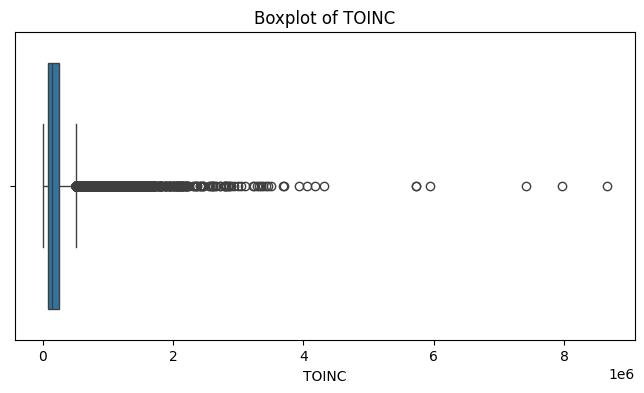

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=selected_df["TOINC"])
plt.title("Boxplot of TOINC")
plt.show()

# **Exploratory Data Analysis**

### ***Log Transformation***

### **`TOINC`**

In [ ]:
selected_df = selected_df.copy()
selected_df["TOINC"] = np.log1p(selected_df["TOINC"])

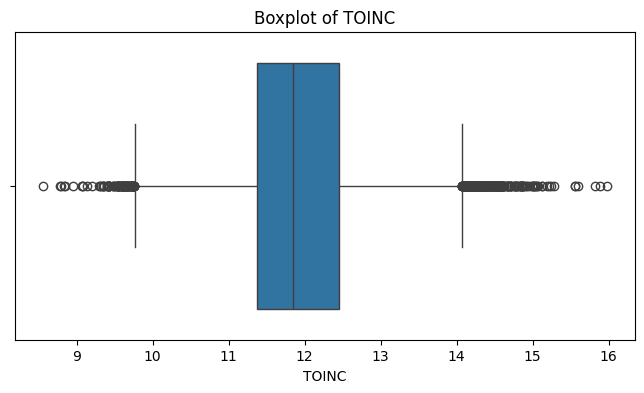

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=selected_df["TOINC"])
plt.title("Boxplot of TOINC")
plt.show()

### ***Standardization***

In [ ]:
selected_df = selected_df.copy()
scaler = StandardScaler()
selected_df[['TOINC']] = scaler.fit_transform(selected_df[['TOINC']])

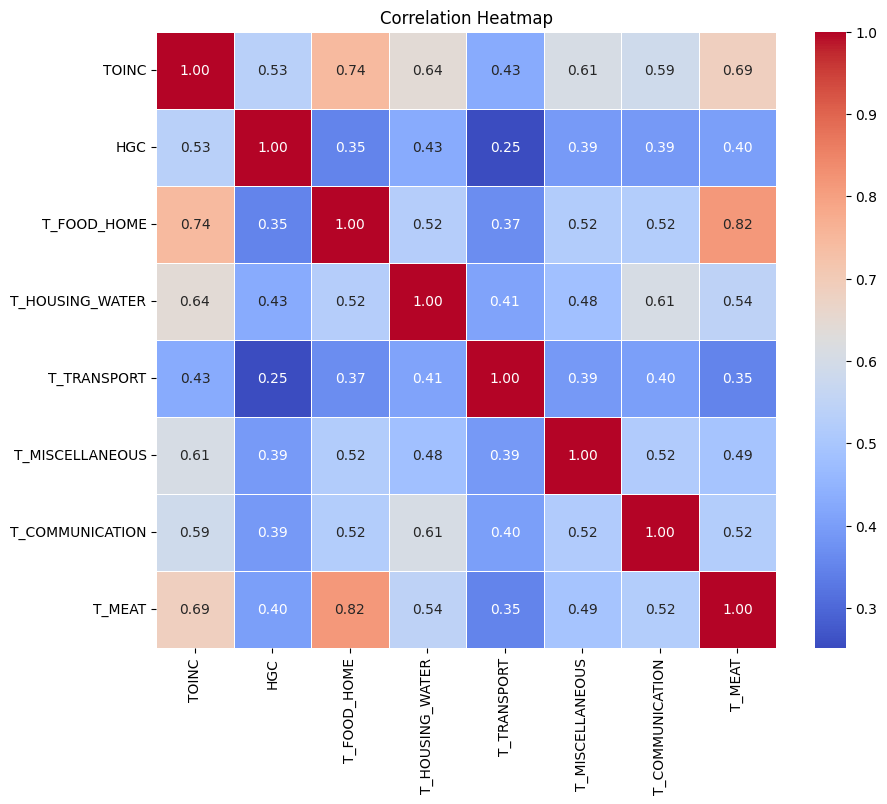

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(selected_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# **Splitting the Dataset**

In [ ]:
X = selected_df.drop(columns=["TOINC"])
y = selected_df["TOINC"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11, test_size=0.2)

# **Initial Model Training**

chuchuchuchu